**Sobre a Empresa**

A empresa Dream Housing Finance lida com todos os tipos de empréstimos para habitação. Ela está presente em áreas urbanas, semiurbanas e rurais. O cliente primeiro solicita um empréstimo para habitação e a empresa valida a elegibilidade do cliente para o empréstimo.

**Problema**

A empresa deseja automatizar o processo de elegibilidade de empréstimos (em tempo real) com base nos detalhes fornecidos pelo cliente ao preencher o formulário de inscrição on-line. Esses detalhes incluem gênero, estado civil, educação, número de dependentes, renda, valor do empréstimo, histórico de crédito e outros. Para automatizar esse processo, eles propuseram um problema para identificar os segmentos de clientes elegíveis para valores de empréstimos, a fim de direcionar especificamente esses clientes. Eles forneceram um conjunto de dados parcial para este problema.

**Fonte: https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval**

**Sobre o DataSet**<br>
* **Loan_ID** - Chave de identificação do cliente<br>
* **Gender** - Gênero do cliente <br>
* **Married** - Cliente casado? (sim/não)<br>
* **Dependents** - Número de dependentes<br>
* **Education** - Grau de escolaridade<br>
* **Self_Employed** - É Autônomo? (sim/não)<br>
* **ApplicantIncome** - Renda do aplicante<br>
* **CoapplicantIncome** - Renda do coaplicante<br>
* **LoanAmount** - Valor do empréstimo<br>
* **Loan_Amount_Term** - Condição de pagamento<br>
* **Credit_History** - Histórico de pagamento (0 - não atende às diretrizes / 1 - atende às diretrizes)<br>
* **Property_Area** - Urbano / Semi-Urbano / Rural<br>
* **Loan_Status** - Empréstimo aprovado? (y- sim | n - não)<br>

## Importando bibliotecas e Dataset

In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression

#Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings("ignore")

In [58]:
#Carregando os dados que serão utilizados na análise
df_train = pd.read_csv('loan_sanction_train.csv')

## Entendendo o dataset

Antes de iniciarmos a análise, precisamos conhecer um pouco melhor o dataset que temos em mãos:

In [59]:
#Visualizando as 10 primeiras linhas dos dados de treino:
df_train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [60]:
#Verificando quantos dados únicos temos em cada variável 
df_train.nunique().sort_values()

Gender                 2
Married                2
Education              2
Self_Employed          2
Credit_History         2
Loan_Status            2
Property_Area          3
Dependents             4
Loan_Amount_Term      10
LoanAmount           203
CoapplicantIncome    287
ApplicantIncome      505
Loan_ID              614
dtype: int64

In [61]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


Na linha acima, é possível observar algumas estatísticas descritivas sobre o nosso dataset.
Podemos tirar alguns insights sobre os dados com base na tabela acima, como:
* Na coluna count, podemos observar que algumas colunas tem valores faltantes em sua composição (ex. LoanAmount e Credit_History, serão tratados futuramente)
* é possível observar que temos outliers nas variáveis numéricas, principalmente nas colunas ApplicantIncome e CoapplicantINcome (renda do aplicante e co-Aplicante respectivamente) já que sua média está descolada da mediana (neste caso representada pela coluna 50%)
* 84% dos clientes possuem bom histórico de crédito (média de Credit_history - variável Dummy (0 e 1)).

In [62]:
#Entendendo o tipo de dado de cada coluna
df_train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

### Analisando dados faltantes (Null)


Quantidade de Missing values por coluna:

In [63]:
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

% de Missing values por coluna:

In [64]:
df_train.isnull().mean().sort_values(ascending = False)

Credit_History       0.081433
Self_Employed        0.052117
LoanAmount           0.035831
Dependents           0.024430
Loan_Amount_Term     0.022801
Gender               0.021173
Married              0.004886
Loan_ID              0.000000
Education            0.000000
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

Como podemos ver a coluna Credit_history é a que mais possui valores missings (8% dos valores). <br>
O tratamento desses dados faltantes será realizado após a divisão entre treino e teste.

## Análise de Variáveis

Serão apresentados alguns gráficos e tabelas de frequência com o objetivo de analisarmos a distribuição dos dados e quais variáveis podem ser úteis para treino do modelo.

Após a apresentação dos gráficos e tabelas, é possível encontrar alguns comentários sobre os achados.

In [10]:
#Separando tipo de variáveis
columns = list(df_train.columns)
cat =  list([c for c in df_train if df_train[c].dtype == 'object' ]) #separando colunas com variáveis categóricas

id = cat.index('Loan_ID') 
cat.pop(id) #Excluindo variável LoanID
stat = cat.index('Loan_Status')
cat.pop(stat) #Excluindo variável Loan_Status
cat.extend(['Credit_History', 'Loan_Amount_Term']) #Adicionando variáveis Credit_history e Loan_amount_term
print(cat)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History', 'Loan_Amount_Term']


In [11]:
num = list(df_train._get_numeric_data().columns)
a = num.index('Credit_History')
num.pop(a)
b = num.index('Loan_Amount_Term')
num.pop(b)
print(num)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [12]:
# cria o pivot table
pivot_table = pd.pivot_table(df_train, values = 'LoanAmount', columns='Loan_Status', index='Gender', aggfunc='count')

# calcula o percentual de funcionários que deixaram a empresa
pivot_table['Approved%'] = pivot_table.apply(lambda x: f"{(x['Y']/x.sum())*100:.2f}%", axis=1)

# exibe o pivot table atualizado
print(pivot_table)

Loan_Status    N    Y Approved%
Gender                         
Female        36   73    66.97%
Male         140  330    70.21%


66.97% das mulheres do Dataset tiveram crédito aprovado, enquanto para o gênero masculino, 70.21% foram aprovados.

In [13]:
# cria o pivot table
pivot_table = pd.pivot_table(df_train, values = 'LoanAmount', columns='Loan_Status', index='Education', aggfunc='count')

# calcula o percentual de funcionários que deixaram a empresa
pivot_table['Approved%'] = pivot_table.apply(lambda x: f"{(x['Y']/x.sum())*100:.2f}%", axis=1)

# exibe o pivot table atualizado
print(pivot_table)

Loan_Status     N    Y Approved%
Education                       
Graduate      134  331    71.18%
Not Graduate   47   80    62.99%


Para a variável Educação, 71.18% dos Graduados foram aprovados, enquanto 62.99% dos não graduados foram aprovados.
Não há diferença relevante entre as categorias, o que provavelmente significa que essa variável não possui importância significativa para o modelo.

In [14]:
# cria o pivot table
pivot_table = pd.pivot_table(df_train, values = 'LoanAmount', columns='Loan_Status', index='Married', aggfunc='count')

# calcula o percentual de funcionários que deixaram a empresa
pivot_table['Approved%'] = pivot_table.apply(lambda x: f"{(x['Y']/x.sum())*100:.2f}%", axis=1)

# exibe o pivot table atualizado
print(pivot_table)

Loan_Status    N    Y Approved%
Married                        
No            75  131    63.59%
Yes          106  278    72.40%


Dentre os casados, 72.40% foram aprovados, e 63.59% dos não casados foram aprovados. 
Novamente, há indícios de que essa variável não possui importância significativa para o modelo

In [15]:
# cria o pivot table
pivot_table = pd.pivot_table(df_train, values = 'LoanAmount', columns='Loan_Status', index='Self_Employed', aggfunc='count')

# calcula o percentual de funcionários que deixaram a empresa
pivot_table['Approved%'] = pivot_table.apply(lambda x: f"{(x['Y']/x.sum())*100:.2f}%", axis=1)

# exibe o pivot table atualizado
print(pivot_table)

Loan_Status      N    Y Approved%
Self_Employed                    
No             148  334    69.29%
Yes             25   54    68.35%


69.29% dos não autônomos foram aprovados, enquanto 68.35% dos autônomos foram aprovados. 

In [16]:
# cria o pivot table
pivot_table = pd.pivot_table(df_train, values = 'LoanAmount', columns='Loan_Status', index='Property_Area', aggfunc='count')

# calcula o percentual de funcionários que deixaram a empresa
pivot_table['Approved%'] = pivot_table.apply(lambda x: f"{(x['Y']/x.sum())*100:.2f}%", axis=1)

# exibe o pivot table atualizado
print(pivot_table)

Loan_Status     N    Y Approved%
Property_Area                   
Rural          66  107    61.85%
Semiurban      53  175    76.75%
Urban          62  129    67.54%


Assim como nas outras variáveis apresentadas até agora, a área de moradia apresenta indíces de aprovação similares:
61% para moradores da área rural, 76% para moradores da áres semiurbana e 67% para moradores da área urbana.

In [17]:
# cria o pivot table
pivot_table = pd.pivot_table(df_train, values = 'LoanAmount', columns='Loan_Status', index='Credit_History', aggfunc='count')

# calcula o percentual de funcionários que deixaram a empresa
pivot_table['Approved%'] = pivot_table.apply(lambda x: f"{(x['Y']/x.sum())*100:.2f}%", axis=1)

# exibe o pivot table atualizado
print(pivot_table)

Loan_Status      N    Y Approved%
Credit_History                   
0.0             78    7     8.24%
1.0             91  367    80.13%


Na variável Histórico de crédito é possível observar um cenário diferente das demais aqui apresentadas. 
apenas 8% dos clientes com histórico de crédito ruim foram aprovados, enquanto 80% dos que tem bom histórico foram aprovados.

Olhando somente para a tabela de frequência, essa variável provavelmente possui significância para nosso modelo. 

Agora vamos observar visualmente por meio de gráficos a frequência das variáveis aqui descritas:

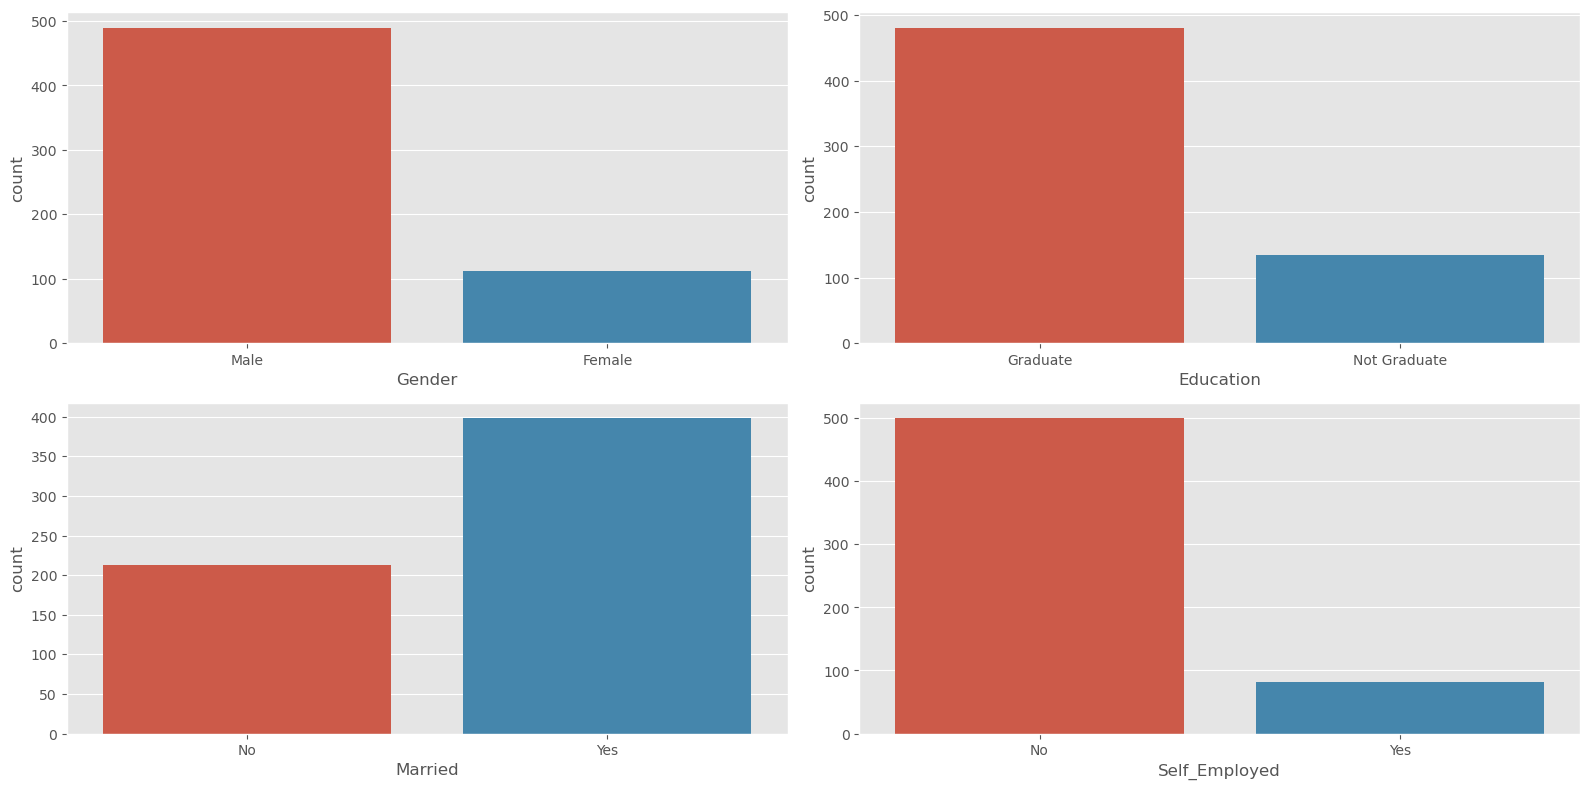

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
_ = sns.countplot(data = df_train, x = df_train['Gender'], ax = axes [0][0]);
_ = sns.countplot(data = df_train, x = df_train['Education'], ax = axes [0][1]);
_ = sns.countplot(data = df_train, x = df_train['Married'], ax = axes [1][0]);
_ = sns.countplot(data = df_train, x = df_train['Self_Employed'], ax = axes [1][1]);
_ = plt.tight_layout()

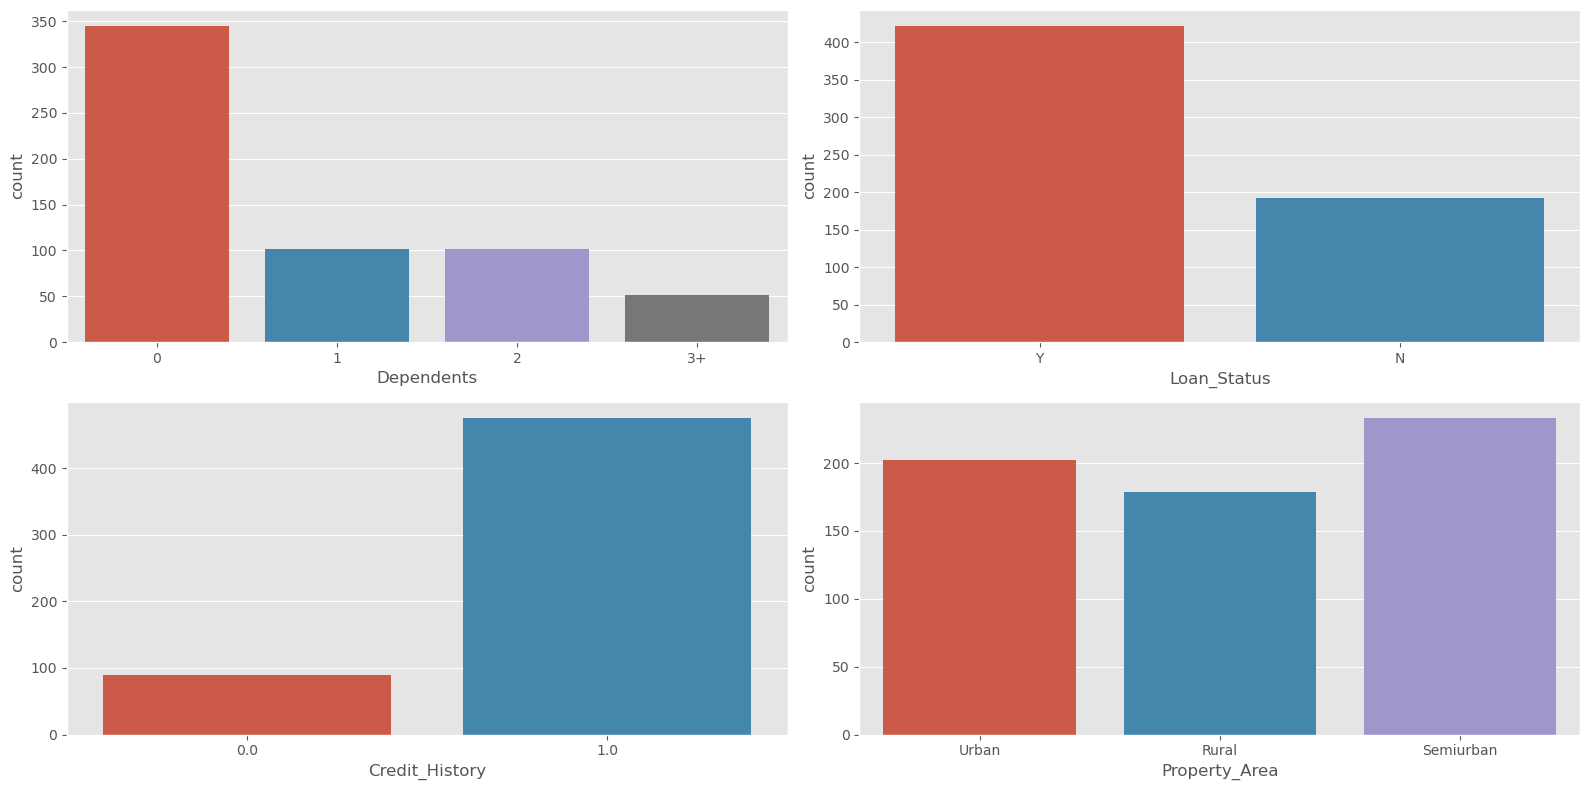

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
_ = sns.countplot(data = df_train, x = df_train['Dependents'], ax = axes[0][0]);
_ = sns.countplot(data = df_train, x = df_train['Loan_Status'], ax = axes[0][1]);
_ = sns.countplot(data = df_train, x = df_train['Credit_History'], ax = axes [1][0]);
_ = sns.countplot(data = df_train, x = df_train['Property_Area'], ax = axes [1][1]);
_ = plt.tight_layout()

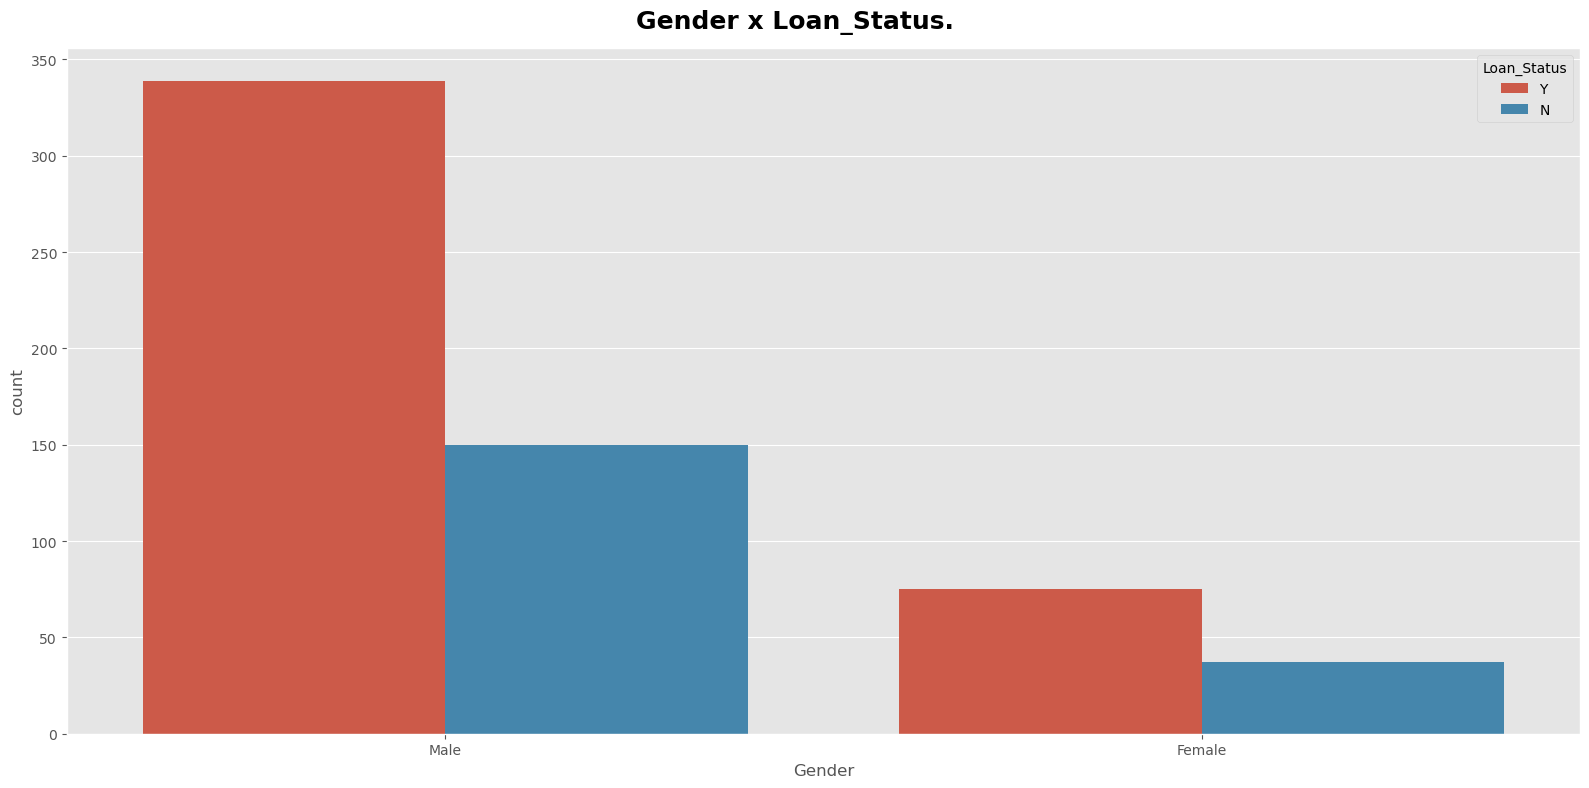

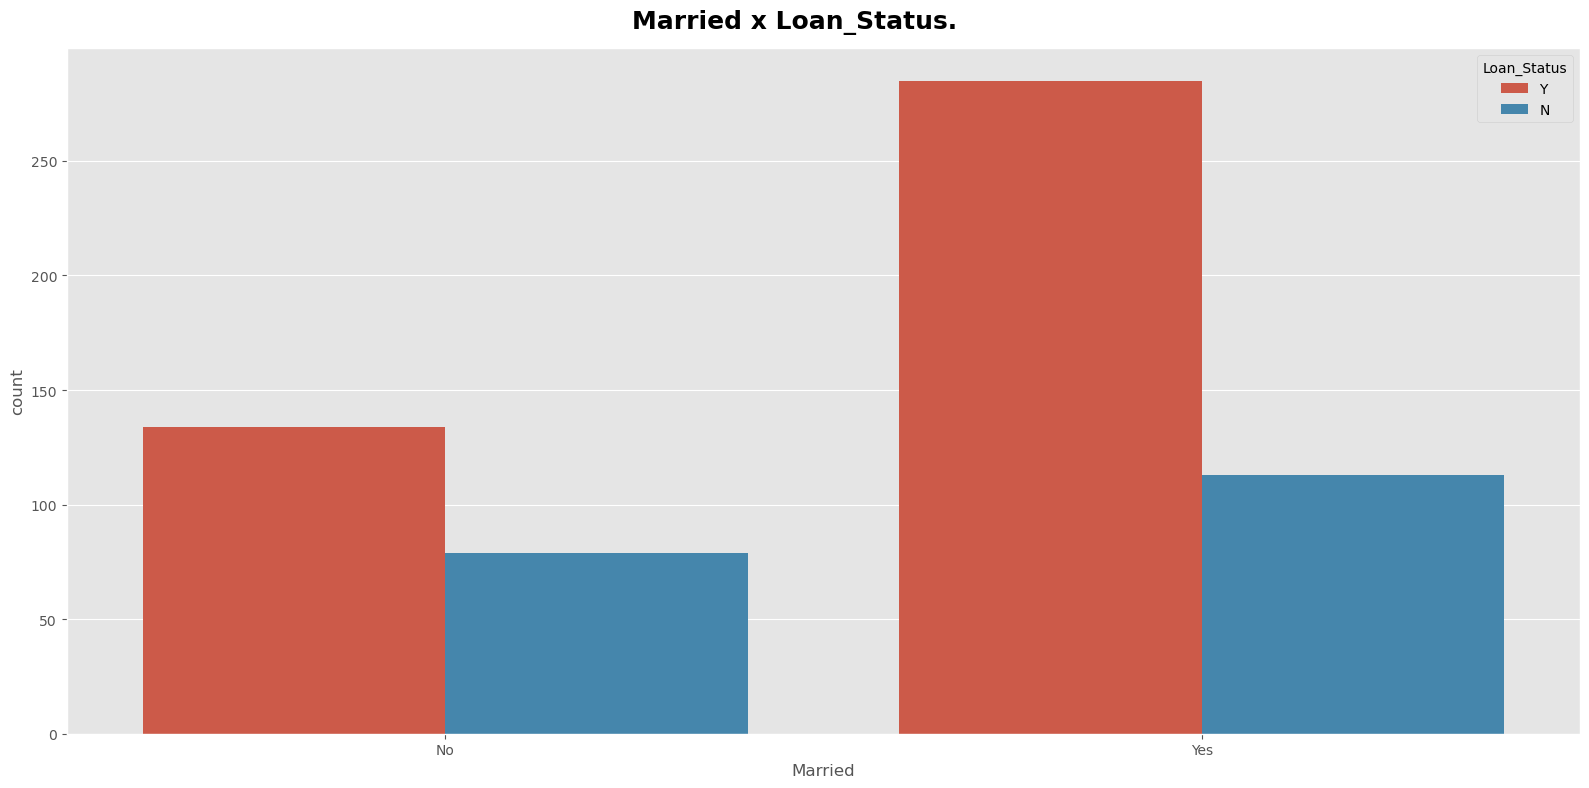

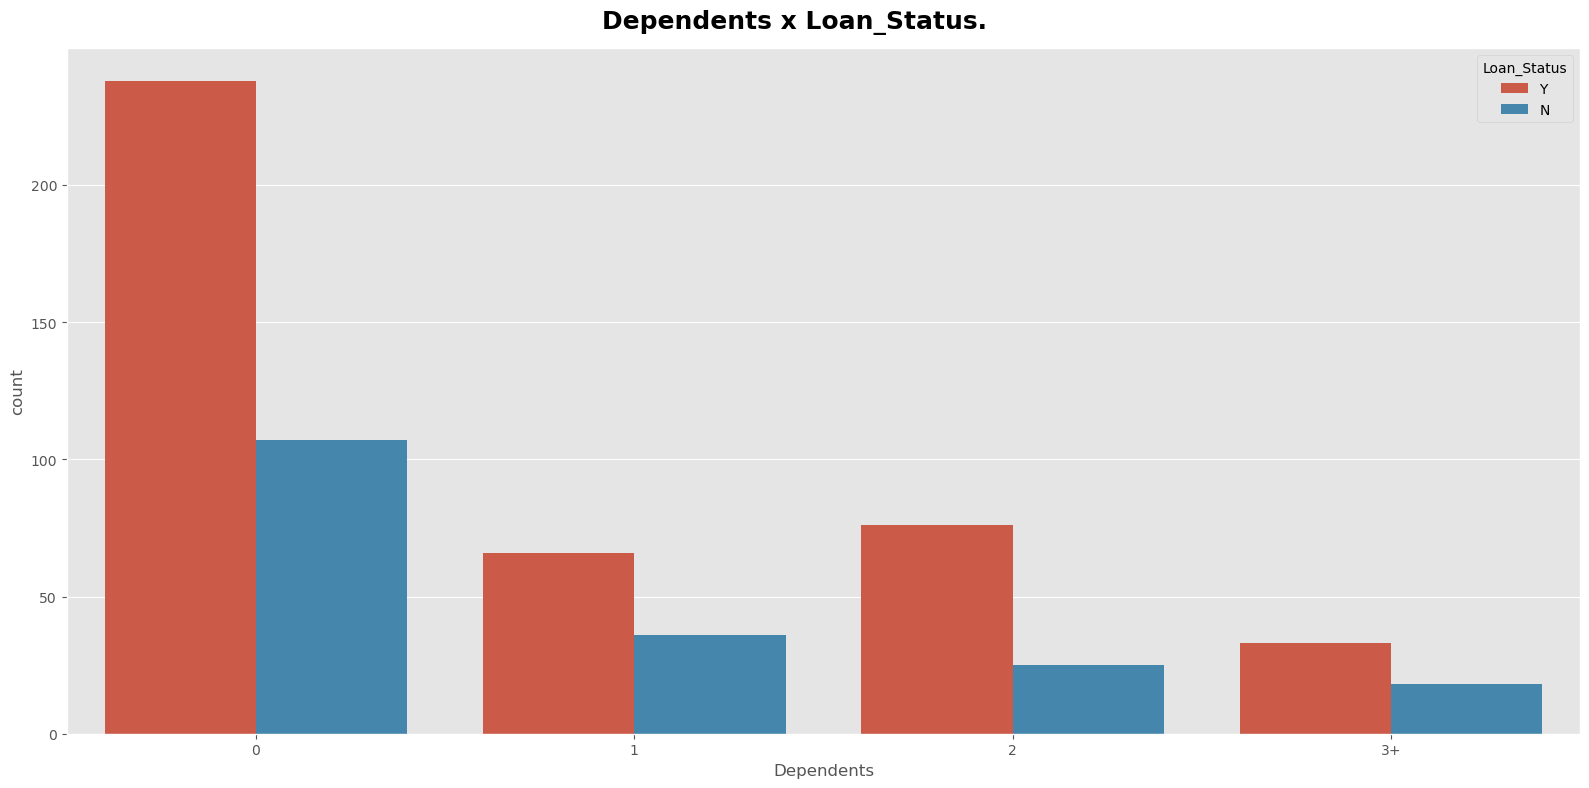

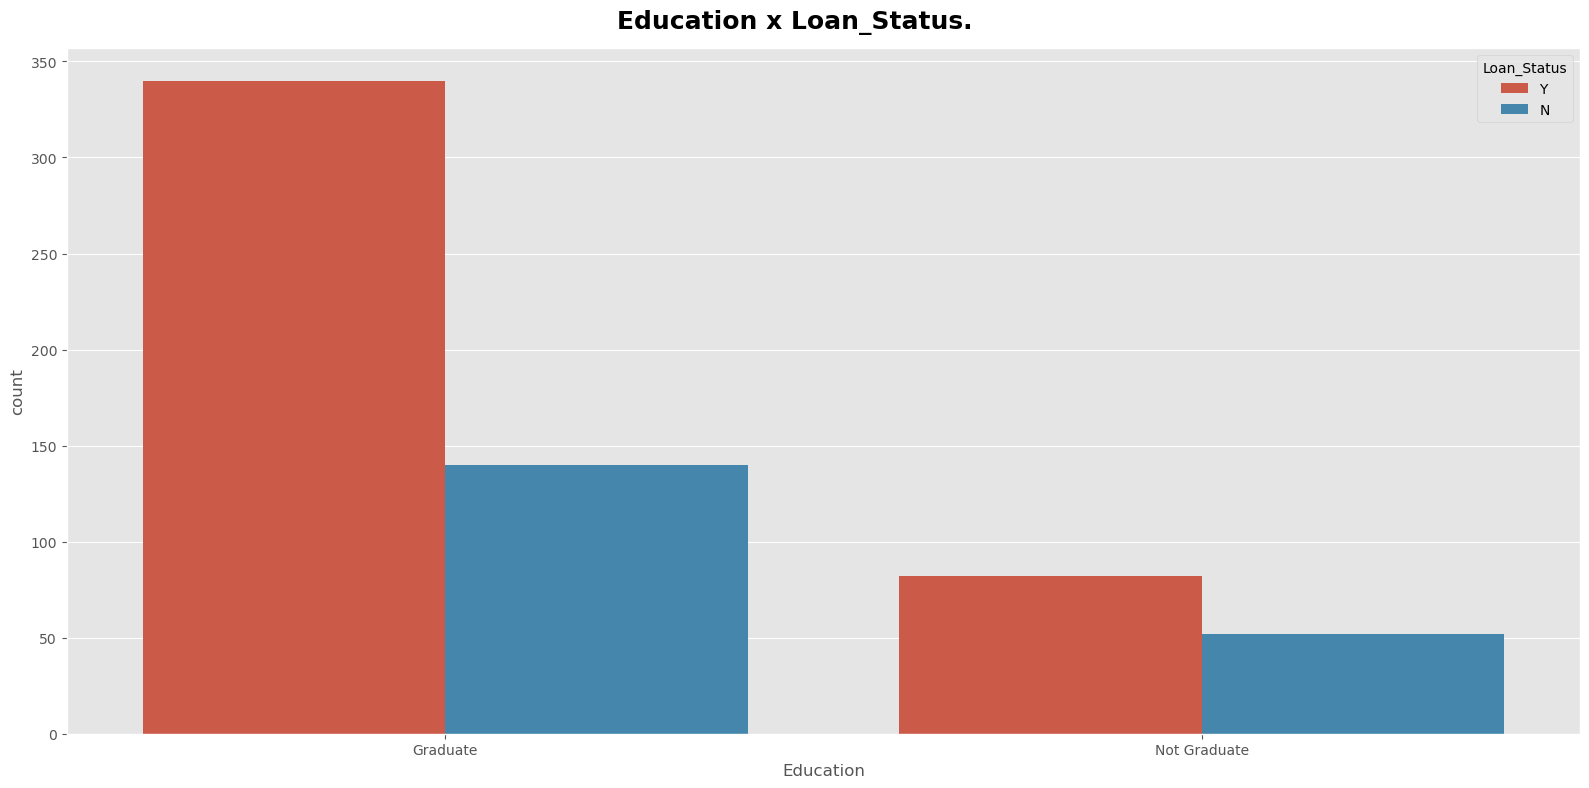

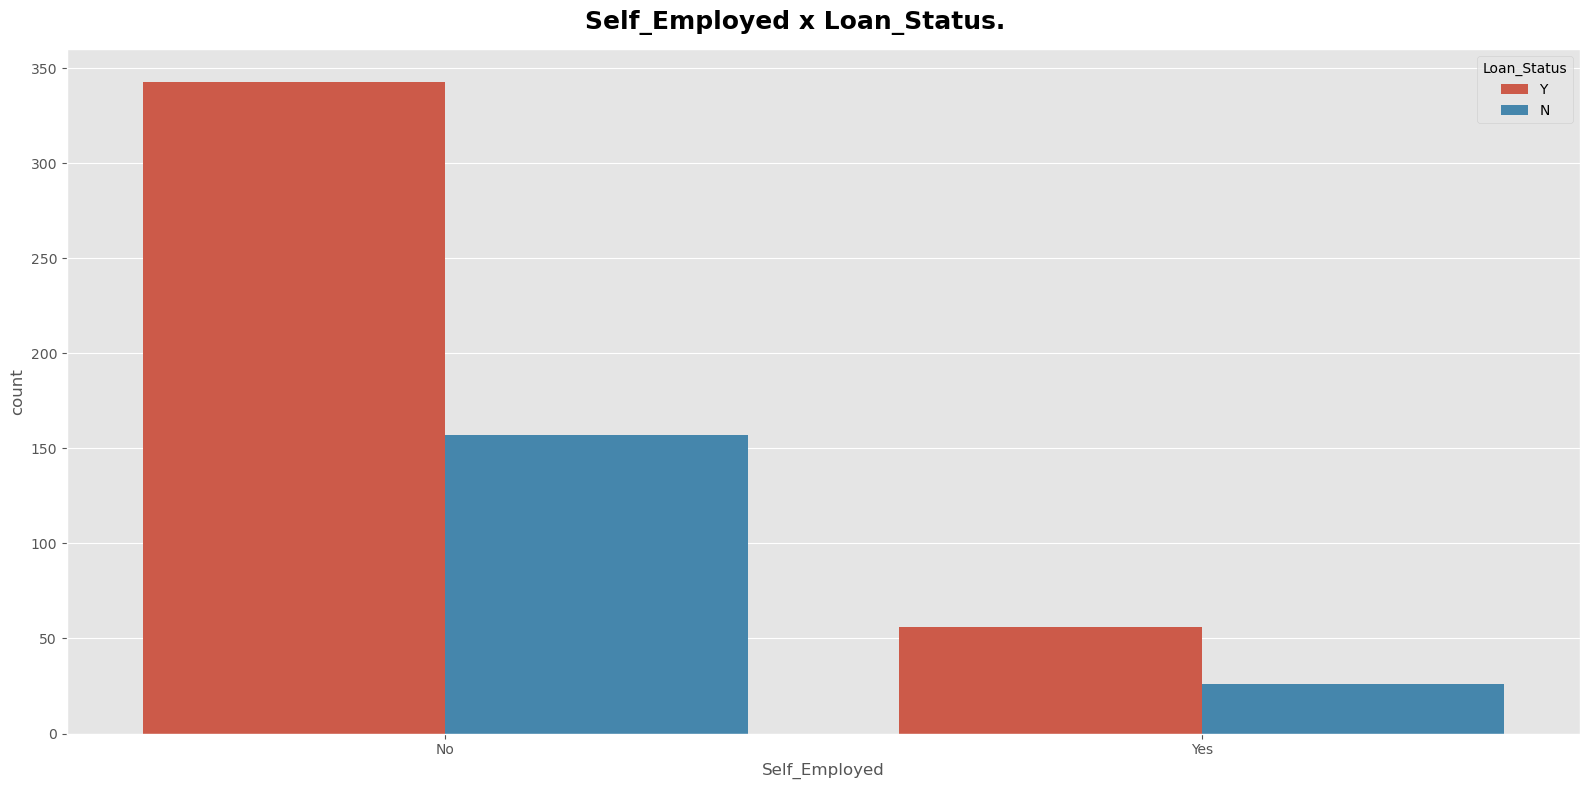

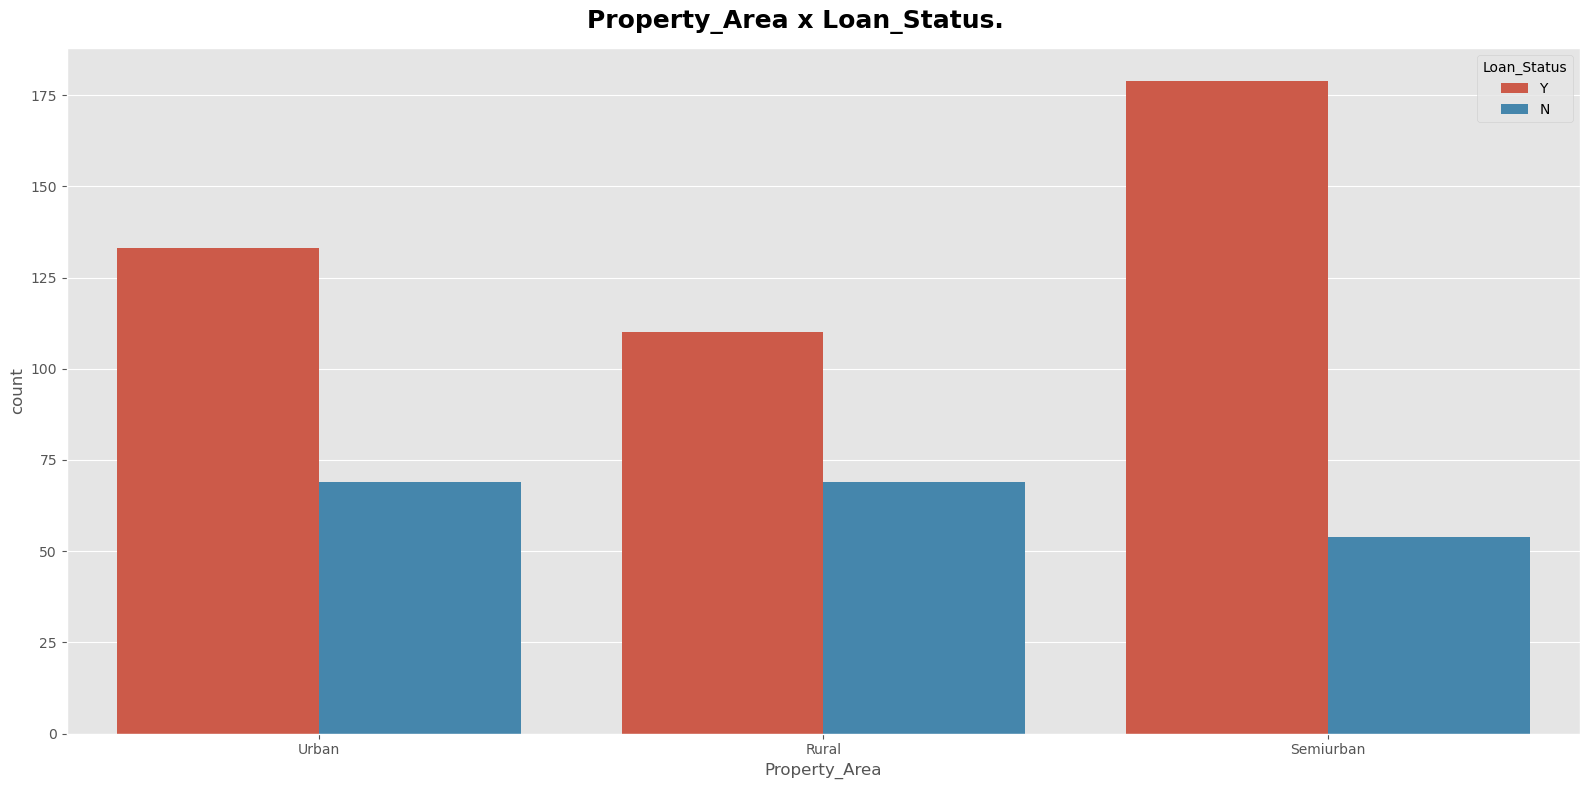

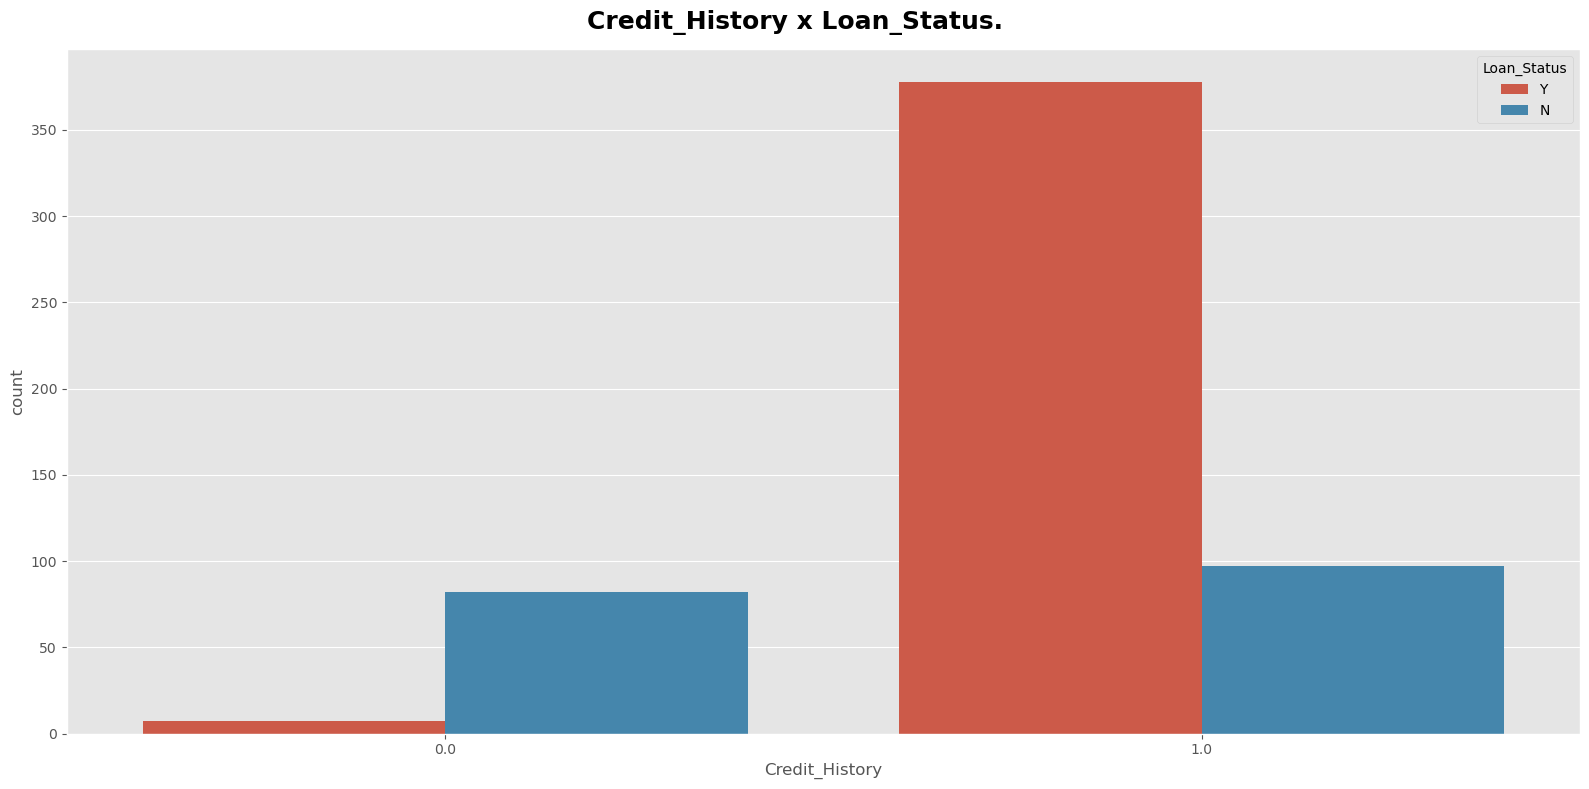

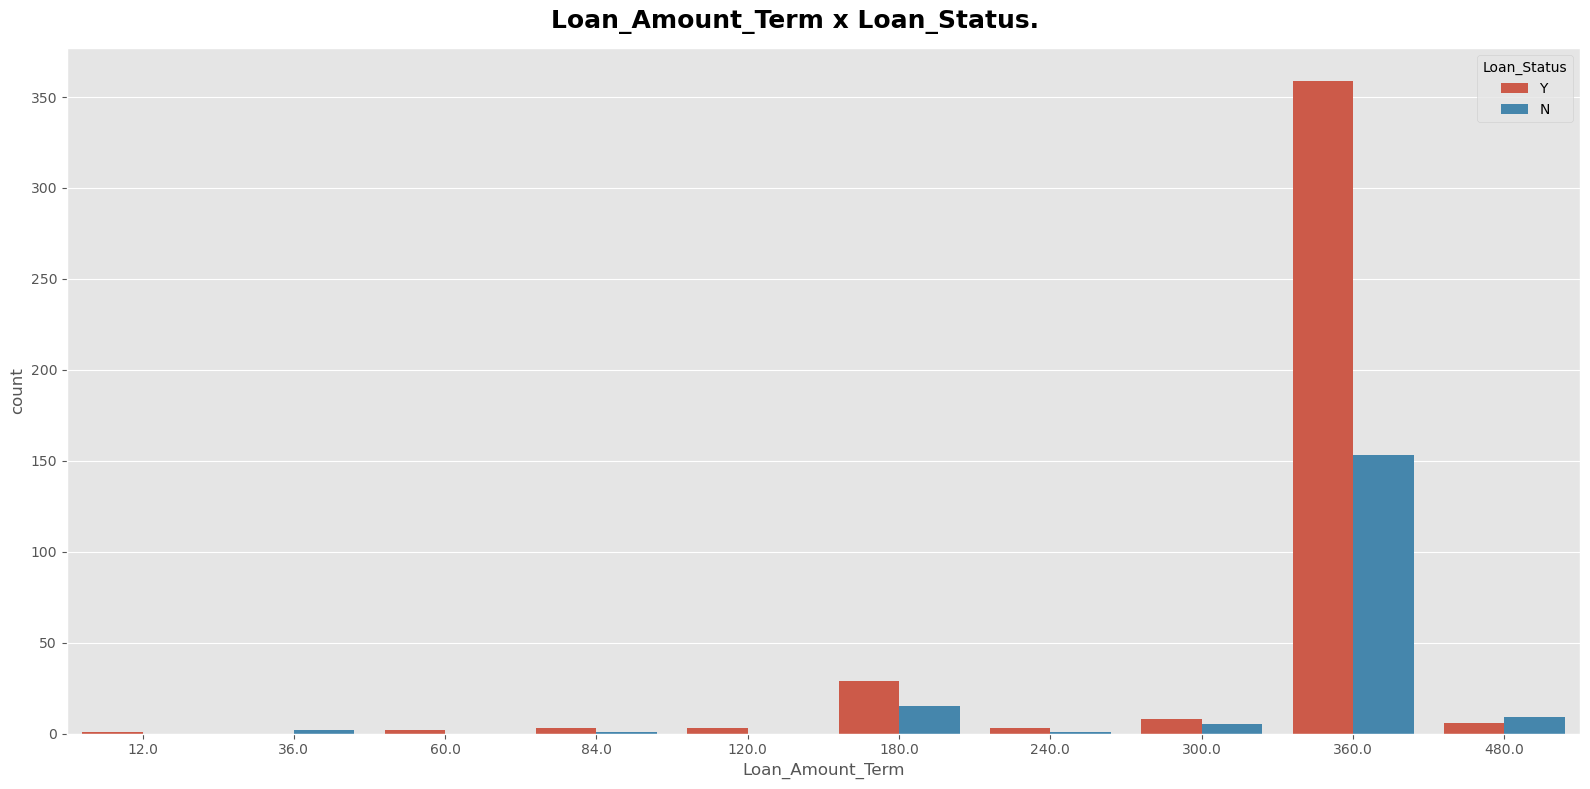

In [20]:
for g in cat:
    fig, axes = plt.subplots(1, 1, figsize=(16, 8))
    sns.countplot(x = df_train[g], hue = df_train['Loan_Status']);
    fig.suptitle(f"{g} x Loan_Status.", fontweight = 'bold', fontsize = 18)
    plt.tight_layout()
    

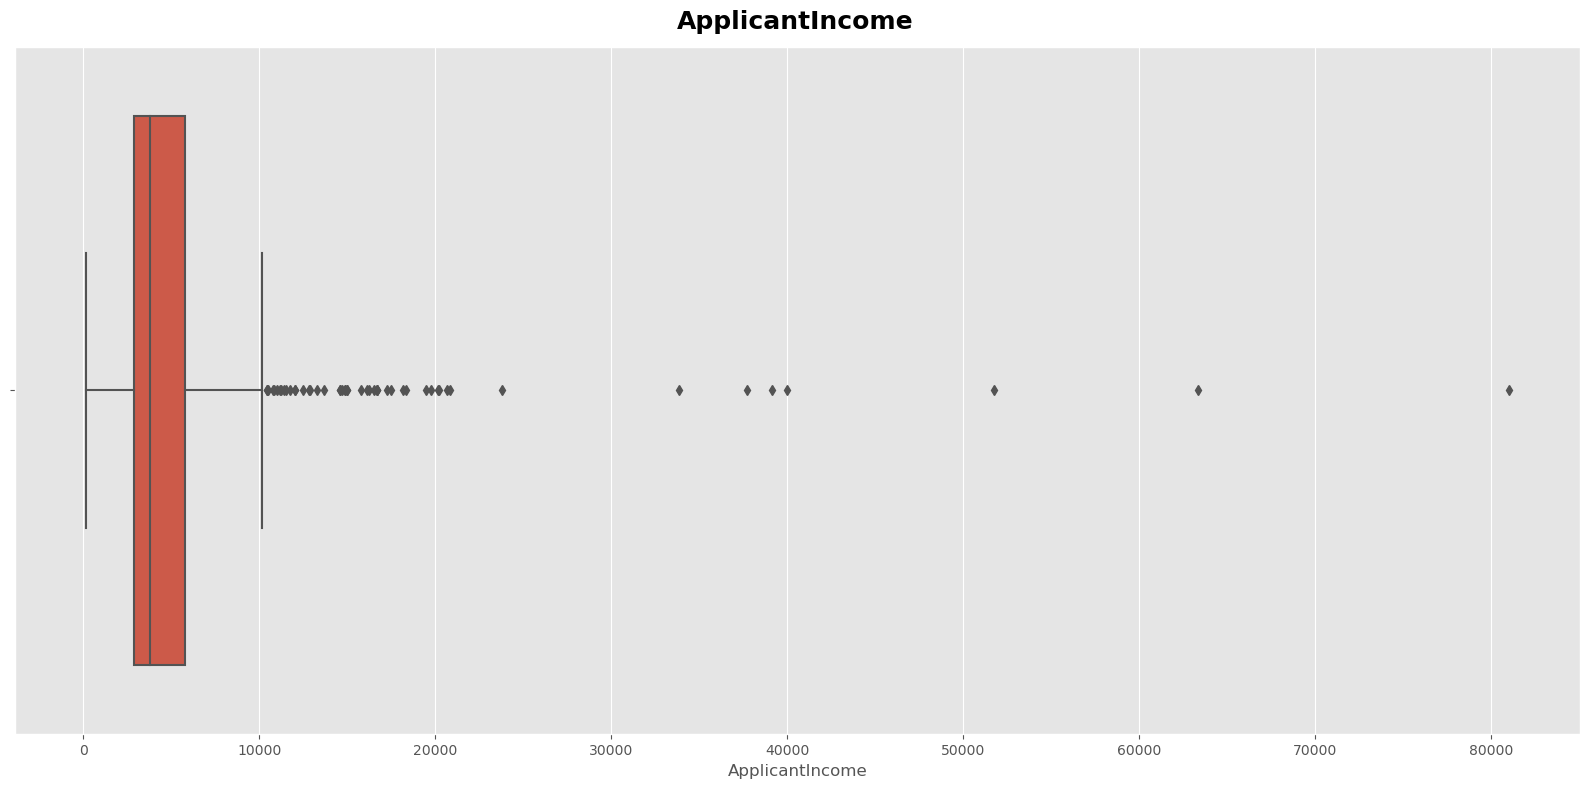

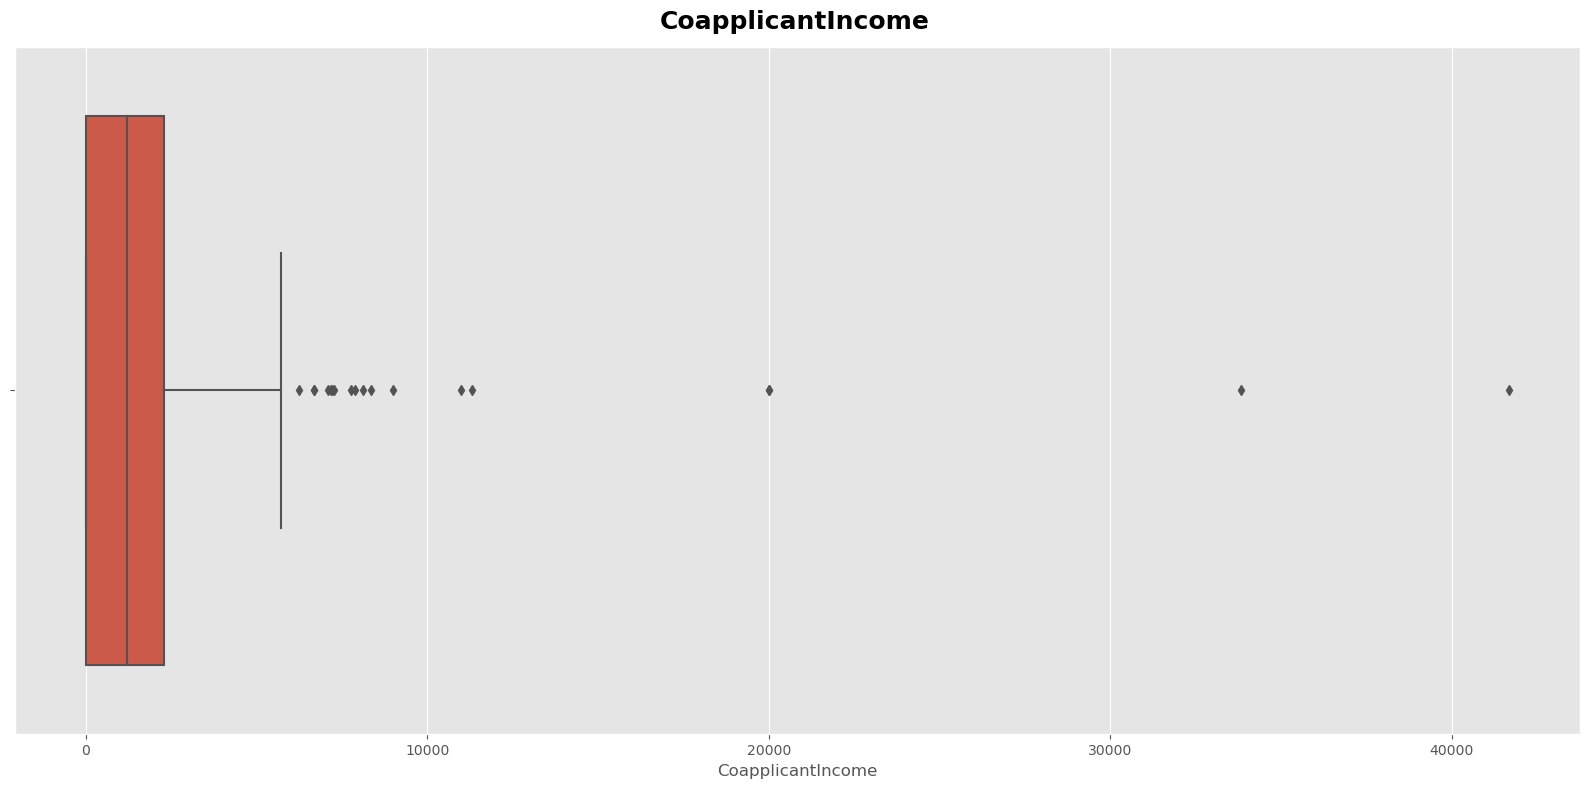

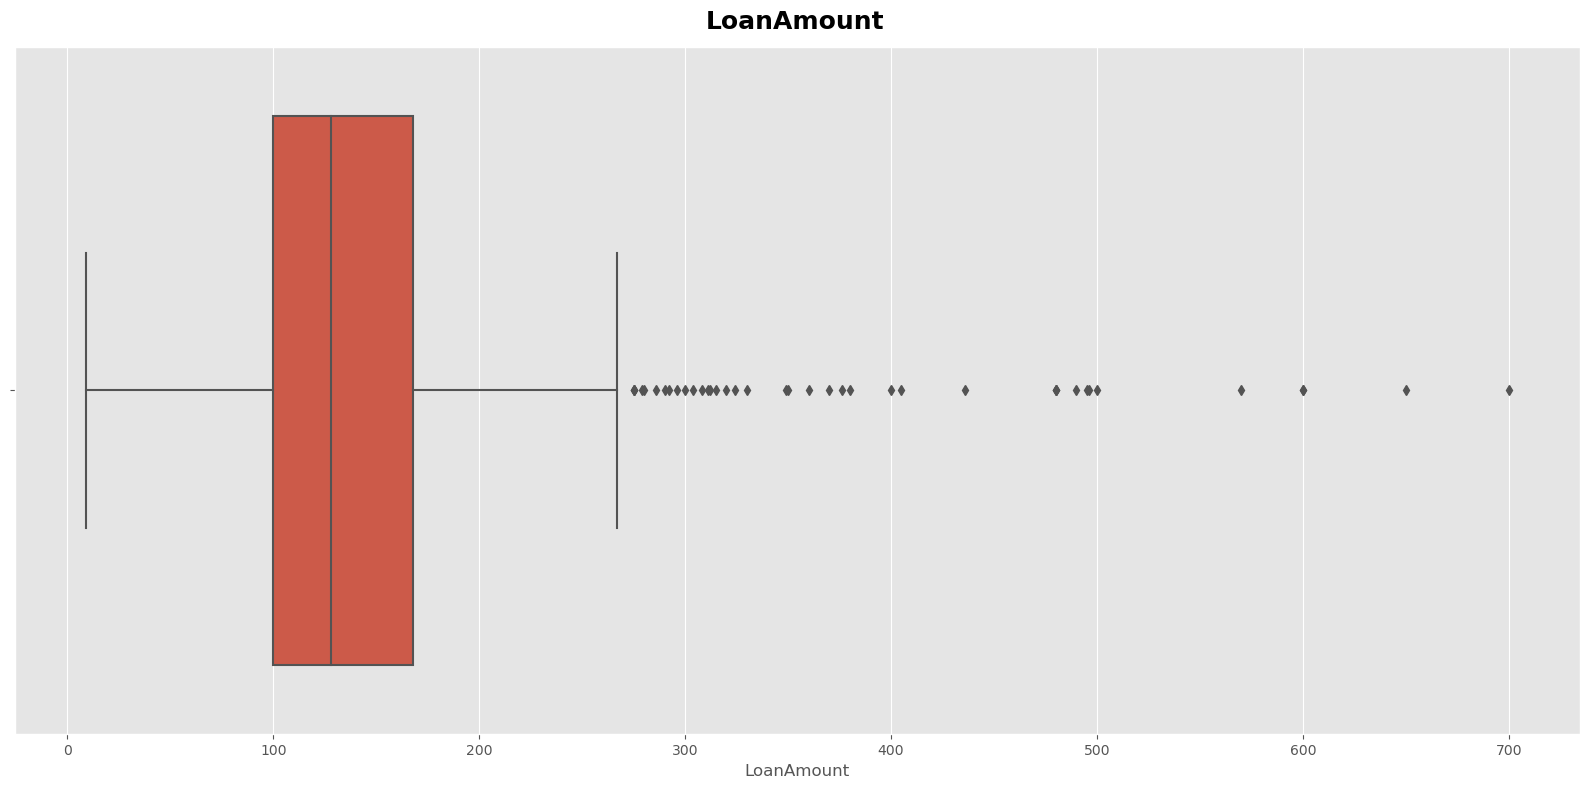

In [21]:
for c in num:
    fig, axes = plt.subplots(1, 1, figsize=(16, 8))
    sns.boxplot(x = df_train[c], data = df_train);
    fig.suptitle(f"{c}", fontweight = 'bold', fontsize = 18)
    plt.tight_layout()

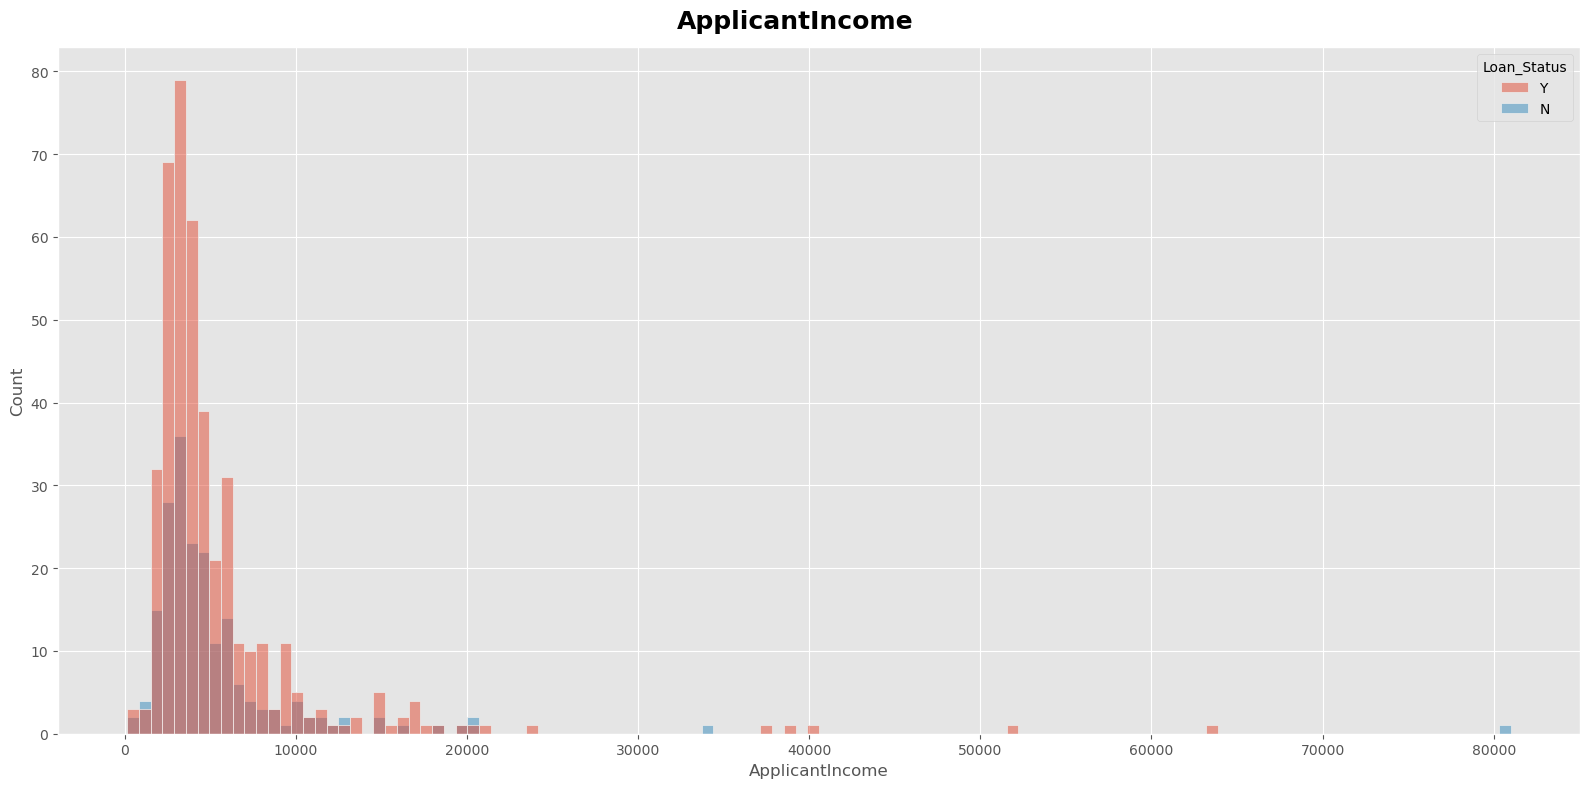

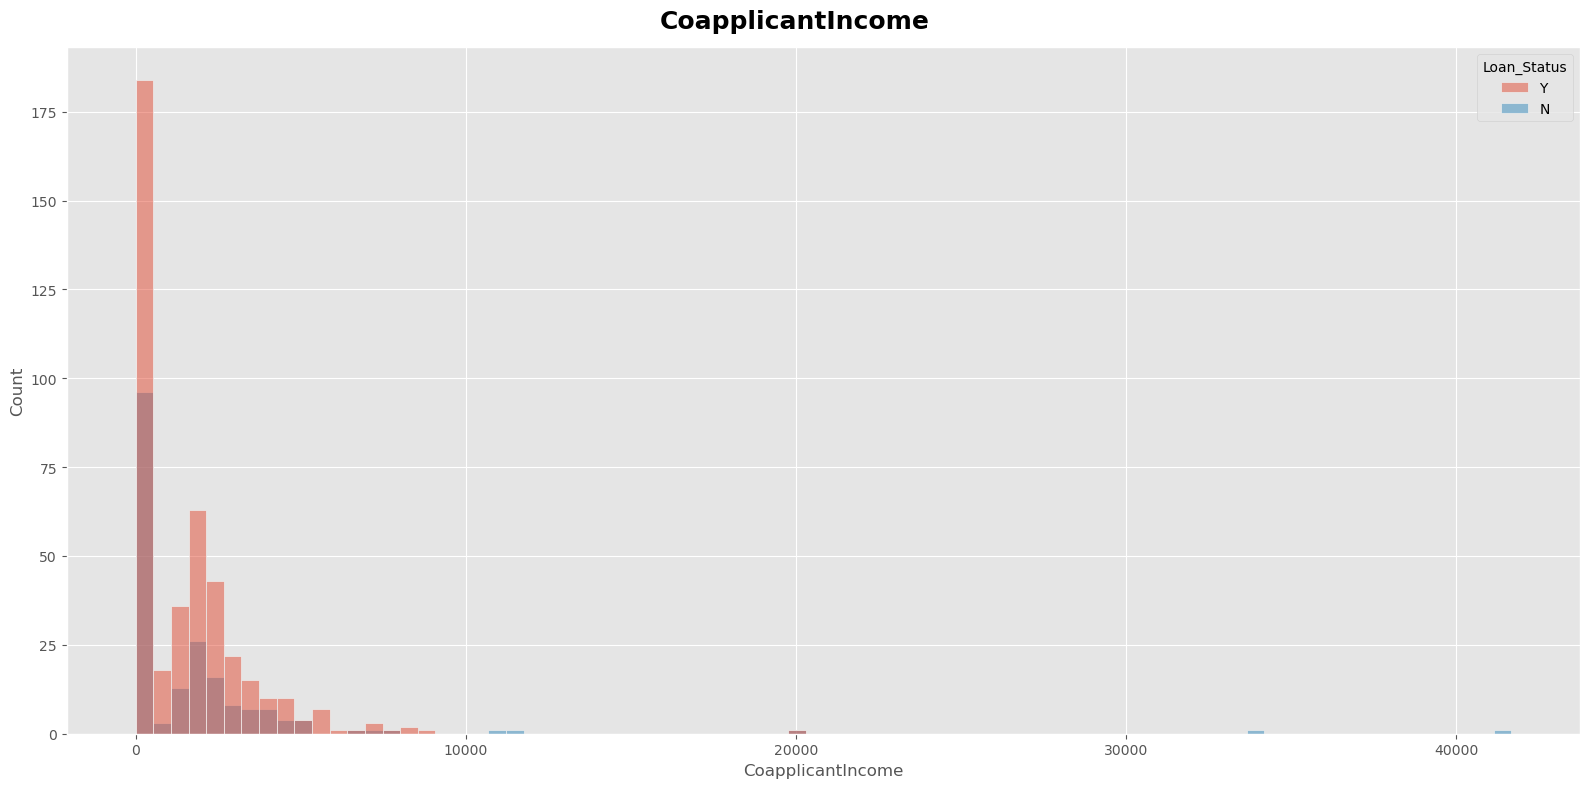

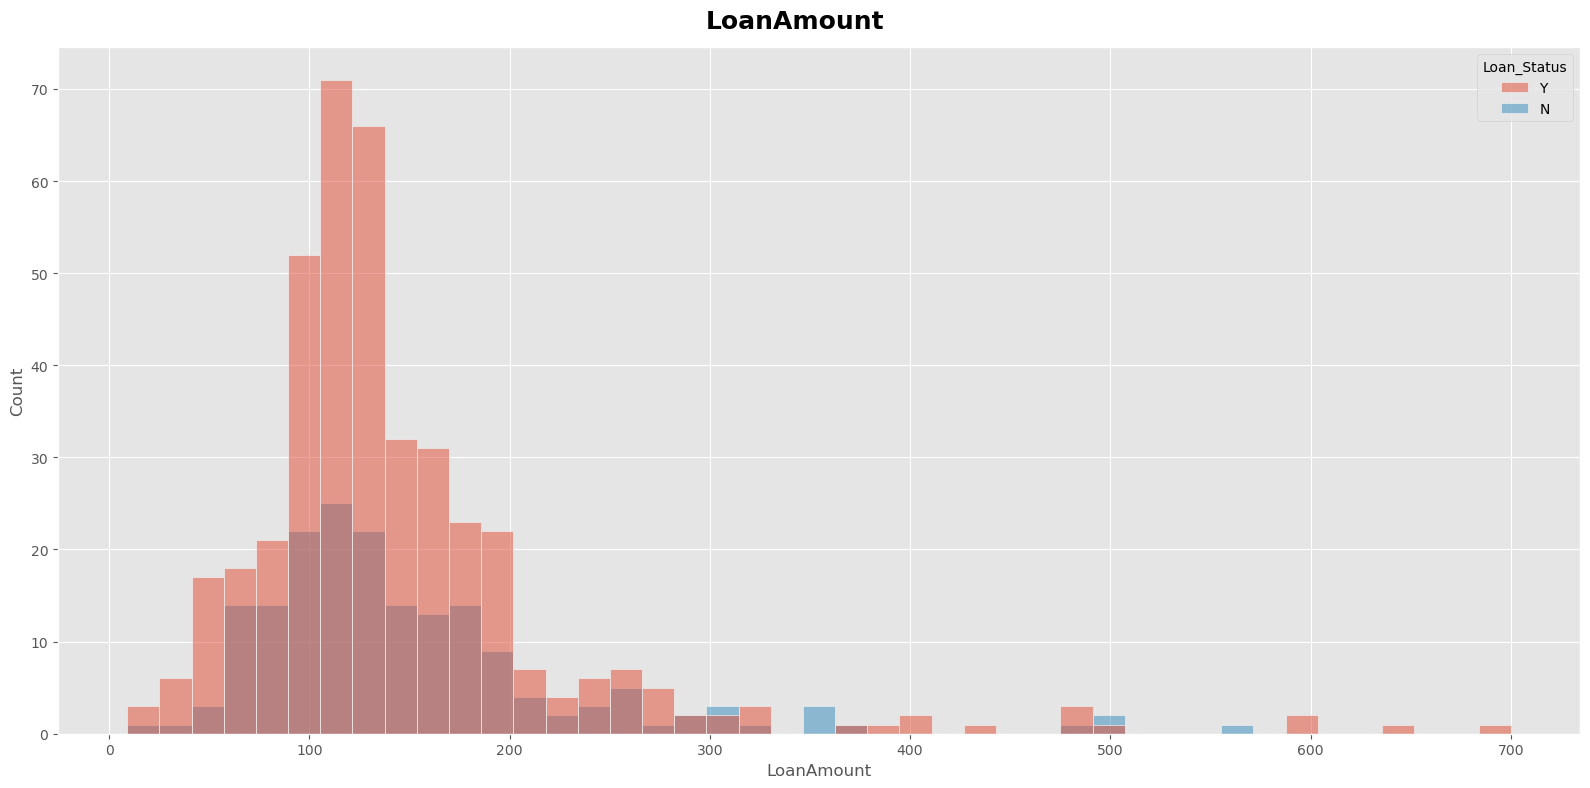

In [22]:
for c in num:
    fig, axes = plt.subplots(1, 1, figsize=(16, 8))
    sns.histplot(x = df_train[c], data = df_train, hue = df_train['Loan_Status']);
    fig.suptitle(f"{c}", fontweight = 'bold', fontsize = 18)
    plt.tight_layout()

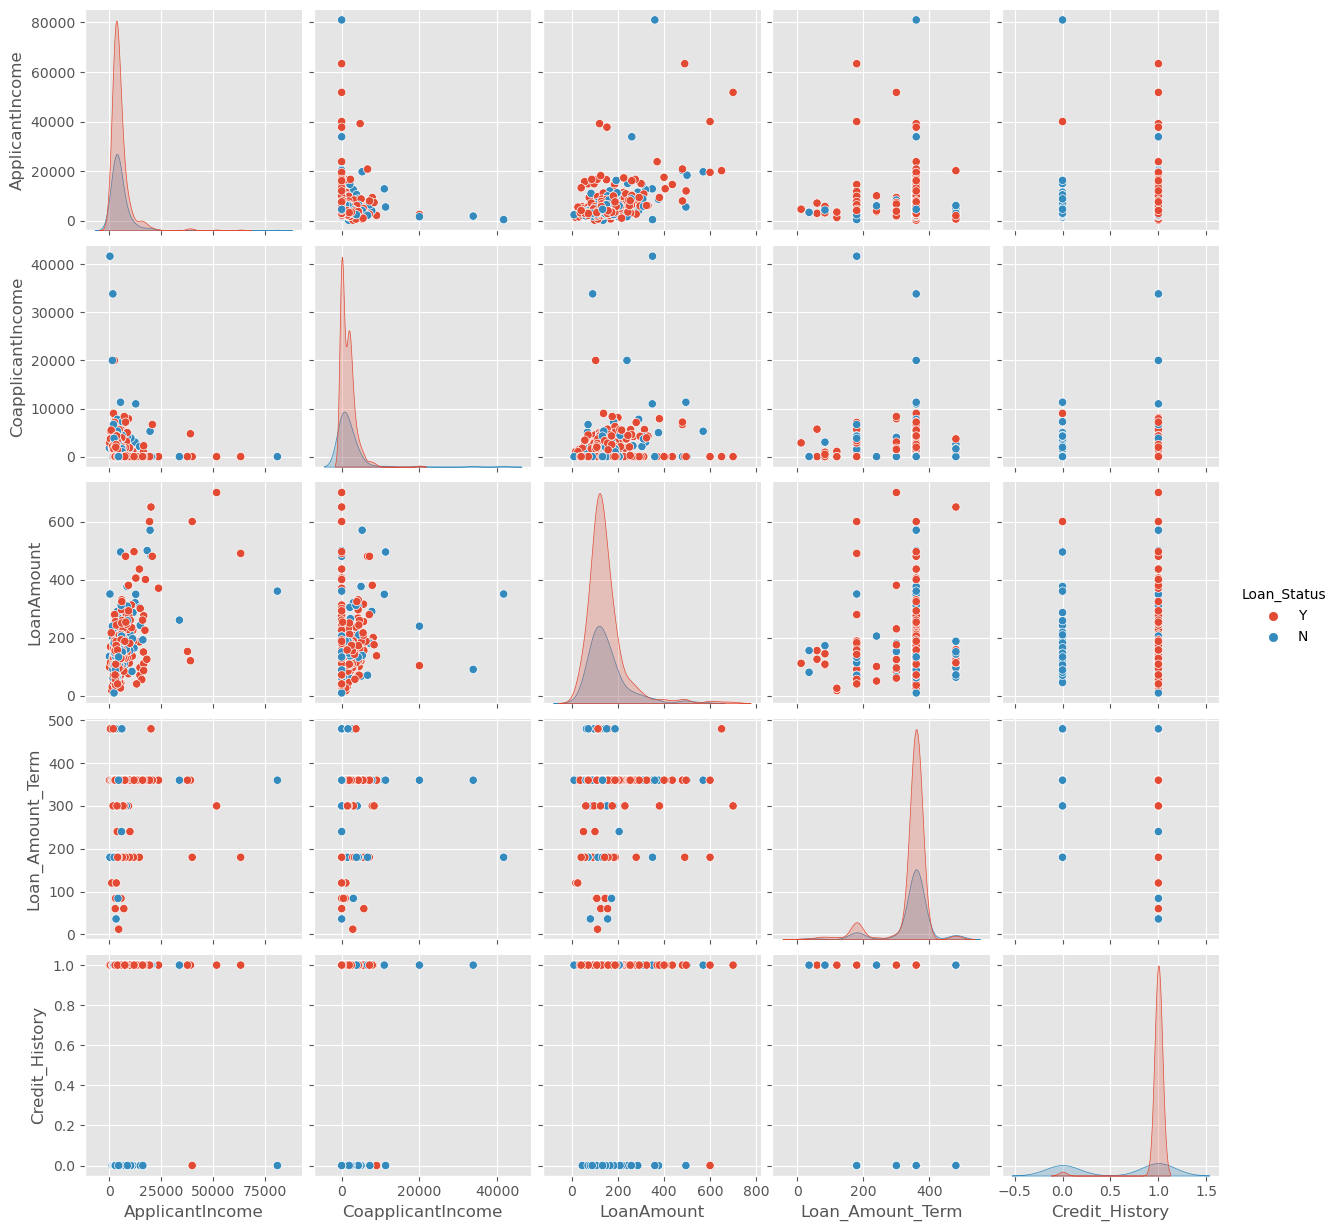

In [22]:
sns.pairplot(df_train, hue = 'Loan_Status');

Conforme foi possível observar nas tabelas de frequência e gráficos, as variáveis Credit_History, ApplicantIncome e CoApplcant Income aparentemente possuem maior poder de separação em relação as outras variáveis apresentadas. 

As variáveis categóricas como Gênero, Grau de escolaridade, Estado Civil e área de moradia não aparentam possuir bom poder de separação, visto que há percentuais altos de aprovação para todas as categorias dessas variáveis.

# Pré Processamento e treinamento do Modelo

### Definição das features e target

## Importante!

Como vimos na análise exploratória, muitas variáveis que possuímos não separam muito bem nossos clientes aprovados e reprovados. <br>

Além disso, é importante pensar em problemas éticos antes de selecionar nossas features, certamente não queremos que nosso modelo distribua pesos maiores para pessoas de determinado gênero, localidade, estado cívil ou Educação.

Para evitar criarmos esse viés, essas variáveis citadas foram excluídas do treinamento do modelo, vamos focar aqui em variáveis mais usuais para decisões de crédito, como tipo de emprego, renda e histórico de crédito.

In [191]:
X = df_train[['Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'Credit_History']]
y = df_train['Loan_Status']

In [192]:
#Separação das variáveis categóricas e numéricas
num = ['ApplicantIncome', 'Credit_History', 'CoapplicantIncome'] #numéricas
cat = ['Self_Employed', ] #categoricas

Para facilitar o pré-processamento dos dados, vamos definir um pipeline para o processamento padrão dos dados faltantes e inconsistências:

* Dados numéricos: será efetuado o imput dos dados missings com a média da coluna, além do escalonamento das variáveis para melhorar a performance do modelo

* Dados categóricos: Também faremos o imput dos missings, mas dessa vez adicionaremos uma categoria "missing"

In [193]:
particoes = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42) 

In [194]:
roc_train = []
roc_test = []
target_train = []
target_test = []
acc_train = []
acc_test = []
prec_train = []
prec_test = []
recl_train = []
recl_test = []
f1_train = []
f1_test = []




for train_index, test_index in particoes.split(X,y): # Aqui colocamos o parâmetro y para que o particionador saiba calcular as proporções
    
    # Separa a base    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Target em Treino e Teste
    target_train.append(np.where(y_train == 'Y',1,0).mean())
    target_test.append(np.where(y_test == 'Y',1,0).mean())
    
    numerical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), ('scaler', MinMaxScaler())])
    categorical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Missing')),('encoder', OneHotEncoder())])
    preprocessor = ColumnTransformer(transformers=[('numerical', numerical_pipeline, num),('categorical', categorical_pipeline, cat)])
    preprocessor.fit(X_train) # fit the preprocessor on training data
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    
    y_train = np.where(y_train == 'Y', 1, 0)
    y_test = np.where(y_test == 'Y', 1, 0)
    
    #Treina o modelo
    
    modelo = LogisticRegression(random_state = 42, fit_intercept = True)
    modelo.fit(X_train, y_train)
    
    # AUC em Treino
    prob_train = modelo.predict_proba(X_train)[:,1]
    ypred_train = modelo.predict(X_train)
    roc_train.append(roc_auc_score(y_train, prob_train))
    
    # AUC em Teste
    prob_test = modelo.predict_proba(X_test)[:,1]
    ypred_test = modelo.predict(X_test)
    roc_test.append(roc_auc_score(y_test, prob_test))
    
    # Métricas de Desempenho
    acc_train.append(accuracy_score(y_train, ypred_train))
    acc_test.append(accuracy_score(y_test, ypred_test))

    prec_train.append(precision_score(y_train, ypred_train, zero_division=0))
    prec_test.append(precision_score(y_test, ypred_test, zero_division=0))
    
    recl_train.append(recall_score(y_train, ypred_train))
    recl_test.append(recall_score(y_test, ypred_test))
    
    f1_train.append(f1_score(y_train, ypred_train))
    f1_test.append(f1_score(y_test, ypred_test))

    
    
resultado2 = pd.DataFrame({"Target em Treino":target_train,
                           "Target em Teste":target_test,
                           "AUC em Treino":roc_train, 
                           "AUC em Teste":roc_test,
                           "Accuracy em Treino":acc_train,
                           "Accuracy em Teste":acc_test,
                           "Precision em Treino":prec_train,
                           "Precision em Teste":prec_test,
                           "Recall em Treino":recl_train,
                           "Recall em Teste":recl_test,
                           "f1 em treino":f1_train,
                           "f1 em teste": f1_test}                    
                           )
resultado2

,Target em Treino,Target em Teste,AUC em Treino,AUC em Teste,Accuracy em Treino,Accuracy em Teste,Precision em Treino,Precision em Teste,Recall em Treino,Recall em Teste,f1 em treino,f1 em teste
0,0.686354,0.691057,0.709054,0.610836,0.808554,0.821138,0.789976,0.800000,0.982196,0.988235,0.875661,0.884211
1,0.686354,0.691057,0.698909,0.712074,0.806517,0.821138,0.786730,0.805825,0.985163,0.976471,0.874835,0.882979
2,0.688391,0.682927,0.703533,0.678266,0.812627,0.804878,0.794258,0.783019,0.982249,0.988095,0.878307,0.873684
3,0.688391,0.682927,0.728178,0.644078,0.816701,0.780488,0.796651,0.766355,0.985207,0.976190,0.880952,0.858639
4,0.686992,0.688525,0.701424,0.681078,0.804878,0.827869,0.786730,0.805825,0.982249,0.988095,0.873684,0.887701


In [195]:
fpr, tpr, thresholds = roc_curve(y_test, ypred_test)

In [196]:
# K-Fold COM estratificação
resultado2.describe().loc[['mean','std']]

,Target em Treino,Target em Teste,AUC em Treino,AUC em Teste,Accuracy em Treino,Accuracy em Teste,Precision em Treino,Precision em Teste,Recall em Treino,Recall em Teste,f1 em treino,f1 em teste
mean,0.687297,0.687298,0.708220,0.665266,0.809855,0.811102,0.790869,0.792205,0.983413,0.983417,0.876688,0.877443
std,0.001032,0.004122,0.011767,0.038799,0.004800,0.019095,0.004472,0.017207,0.001618,0.006470,0.002929,0.011720


## Conclusão sobre os resultados:

**Com base nos resultados apresentados, podemos dizer que o modelo tem um bom desempenho em geral. 
Ele apresenta AUC acima de 0.7 tanto no conjunto de treino quanto no conjunto de teste, o que indica que o modelo é capaz de distinguir bem as classes. Além disso, as métricas de acurácia, precisão, recall e f1-score também são altas em ambos os conjuntos, indicando que o modelo é capaz de classificar bem as observações.**

**A diferença entre as métricas de treino e teste não são muito grandes, o que sugere que não há um grande problema de overfitting. No entanto, a diferença ainda é perceptível em algumas métricas, como AUC e recall, o que indica que talvez possa haver algum grau de overfitting. Portanto, seria importante verificar se há alguma forma de melhorar o modelo para que ele generalize melhor para novos dados.** 

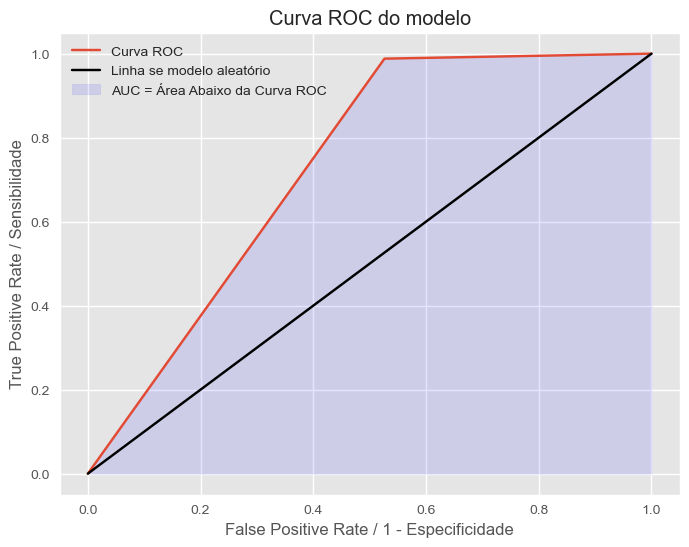

In [197]:
plt.figure(figsize=(8,6))

plt.plot(fpr,tpr, label='Curva ROC')
plt.fill_between(fpr,tpr,color='blue',alpha= 0.1,label = 'AUC = Área Abaixo da Curva ROC')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='black',label='Linha se modelo aleatório')

plt.title("Curva ROC do modelo")
plt.ylabel('True Positive Rate / Sensibilidade')
plt.xlabel('False Positive Rate / 1 - Especificidade')
plt.legend();

0.8278688524590164

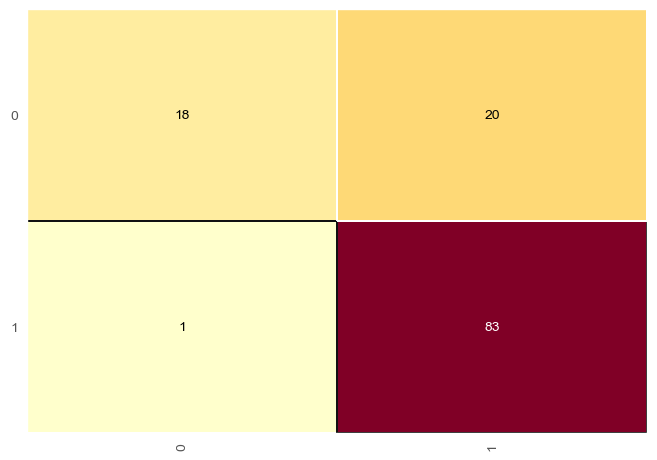

In [198]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(modelo)
cm.fit(X_test,y_test)
cm.score(X_test, y_test)

Como é possível notar, nosso modelo no geral acerta muito bem os casos aprovados ( 83 acertos , 1:1), mas tem um número elevado de erros para previsões negativas. (20 erros 0 : 1), algumas possíveis causas para esse problema:

* Dados desbalanceados no dataset ( Como vimos na Análise exploratória, temos muitos mais casos onde o cliente foi aprovado)
* Escolha incorreta das features do modelo
* Escolha incorreta do modelo a ser utilizado
* Dentre outras.

### Esse não é o final da análise!

Chegamos em um resultado muito bom para meu primeiro projeto!
entretanto, como vimos acima, o modelo apresenta oportunidades de melhoria, e o principal objetivo de continuar estudando esse modelo será reduzir a quantidade de erros do modelo.
Alguns próximos passos podem ser definidos afim de melhorar o desempenho do nosso modelo:

* Revisão dos parâmetros do modelo;
* Verificar novas combinações de features;
* Testar diferentes modelos de classificação;
* Testar diferentes préprocessamentos (Imputer, scaler, encoder, etc)


Tem sugestões, correções, ou até mesmo elogios?
Sinta-se à vontade em entrar em contato comigo, como iniciante, qualquer dica é válida ;D

Linkedin: www.linkedin.com/in/willianmonfrinato

Se você chegou até aqui, muito obrigado pela atenção! <br>
E te aguardo nas atualizações desse modelo! :D